## CQE/UCQ Workshop

Super.tech focuses on quantum benchmarking and optimizations of quantum applications via cross-layer-optimization. 
This notebook is going to be focused on an example of cross-layer-optimization.

We deliver our software via a server that users can access given a token. Anyone can sign up for a $5 free trial for SuperstaQ. Users can access our API via our clients; `qiksit-superstaq` and `cirq-superstaq`. They can also build their own client. Our agenda for today will consist of a tour of the SuperstaQ API, qiskit-superstaq, and applications SuperstaQ. We will also walk through an example of cross layer optimiation by reading and executing code from the [Faster and More Reliable Quantum SWAPs via Native Gates](https://arxiv.org/abs/2109.13199) paper that got us a top ranking submision for the [IBM SWAP challenge](https://research.ibm.com/blog/quantum-open-science-prize-winners). After that, we will work on Github issues for qiskit-superstaq, cirq-superstaq and applications-superstaq to demonstrate the development workflow of SuperstaQ.

## Optimizing the SWAP gate

In [134]:
from typing import Tuple
import numpy as np
import qiskit

from qiskit_superstaq.superstaq_provider import SuperstaQProvider

In [59]:
superstaq_provider = SuperstaQProvider(api_key="token")

In [49]:
qiskit.IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-ornl', group='ornl', project='csc461')>,
 <AccountProvider for IBMQ(hub='ibm-q-startup', group='super-tech-labs', project='default')>,
 <AccountProvider for IBMQ(hub='ibm-q-startup', group='super-tech-labs', project='reservations')>]

In [50]:
ibmq_provider = qiskit.IBMQ.providers()[2]

In [66]:
backend = provider.get_backend("ibmq_bogota")

In [77]:
qc = qiskit.QuantumCircuit(2, 2)
qc.swap(0, 1)
qc.measure([0, 1], [0, 1])
print(qc)

        ┌─┐   
q_0: ─X─┤M├───
      │ └╥┘┌─┐
q_1: ─X──╫─┤M├
         ║ └╥┘
c: 2/════╩══╩═
         0  1 


In [79]:
transpiled_qc = qiskit.transpile(qc, backend)

In [80]:
print(transpiled_qc)

                    ┌───┐     ┌─┐   
      q_0 -> 0 ──■──┤ X ├──■──┤M├───
               ┌─┴─┐└─┬─┘┌─┴─┐└╥┘┌─┐
      q_1 -> 1 ┤ X ├──■──┤ X ├─╫─┤M├
               └───┘     └───┘ ║ └╥┘
ancilla_0 -> 2 ────────────────╫──╫─
                               ║  ║ 
ancilla_1 -> 3 ────────────────╫──╫─
                               ║  ║ 
ancilla_2 -> 4 ────────────────╫──╫─
                               ║  ║ 
          c: 2/════════════════╩══╩═
                               0  1 


In [81]:
pulse_schedule_standard = qiskit.schedule(transpiled_qc, backend)

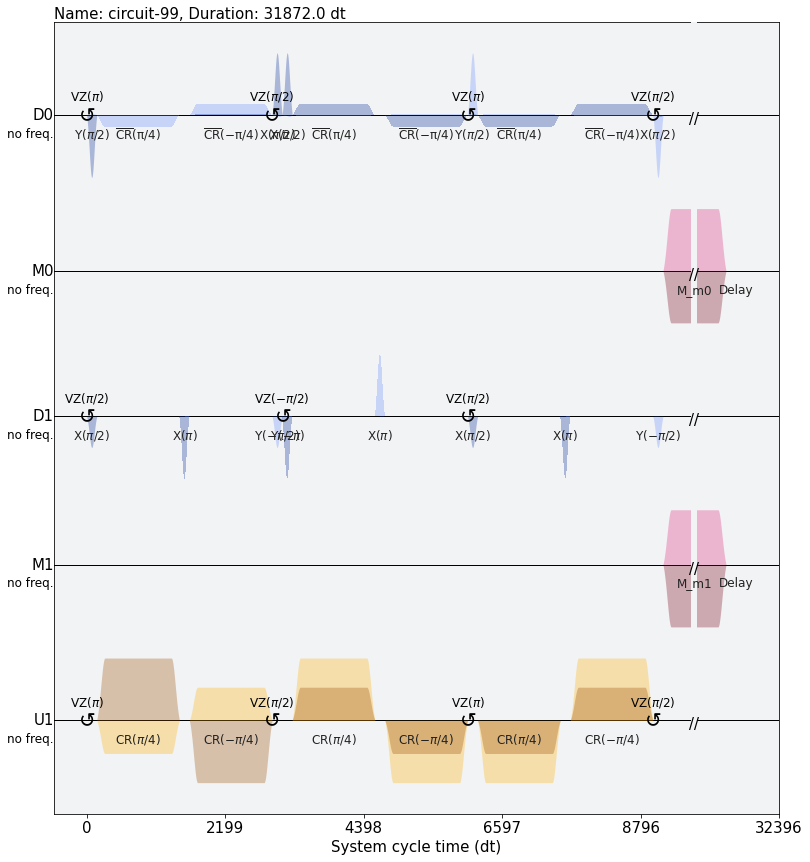

In [82]:
pulse_schedule_standard.draw()

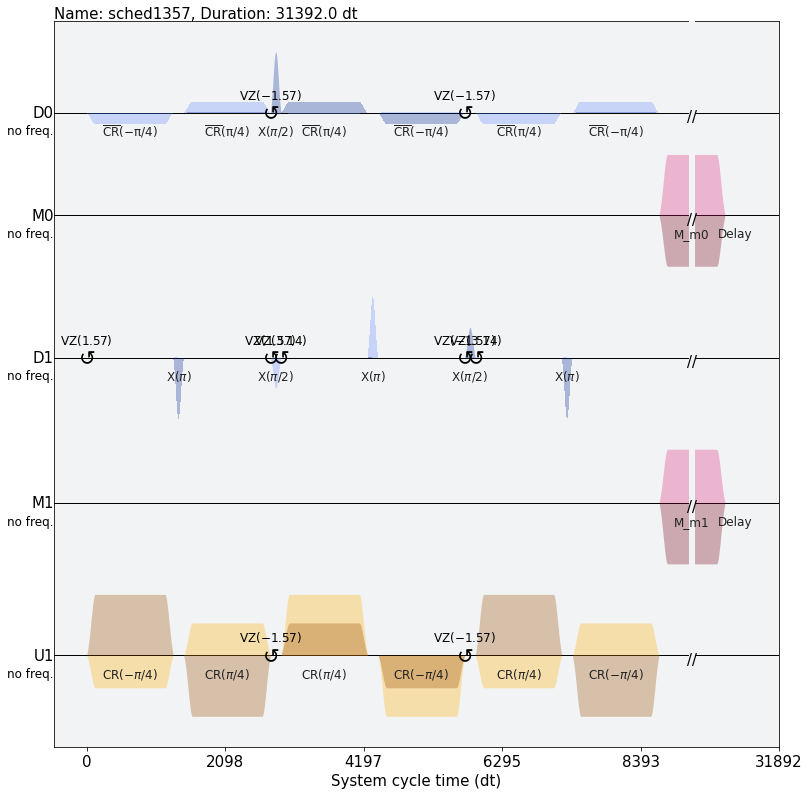

In [83]:
pulse_schedule_optimized = superstaq_provider.ibmq_compile(qc, target="ibmq_bogota_qpu") 
pulse_schedule_optimized.draw()

In [85]:
job1 = qiskit.execute(pulse_schedule_standard, shots=4000, backend=backend)

/home/vtomole/qiskit_superstaq_env/lib/python3.8/site-packages/qiskit/compiler/assembler.py:450: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


In [86]:
job2 = qiskit.execute(pulse_schedule_optimized, shots=4000, backend=backend)

In [91]:
job1.status()

<JobStatus.DONE: 'job has successfully run'>

In [92]:
job2.status()

<JobStatus.DONE: 'job has successfully run'>

In [93]:
job1.result().get_counts()

{'00': 3489, '01': 141, '10': 220, '11': 150}

In [94]:
job2.result().get_counts()

{'00': 3501, '01': 174, '10': 274, '11': 51}

## The following code is how we construct the optimized pulse schedule

In [116]:
ism = backend.defaults().instruction_schedule_map

In [117]:
def _is_fast_cx_orientation(i: int, j: int) -> bool:
    """Returns whether CX(i, j) is faster than CX(j, i).

    While both gates are possible on any connected qubit pairs, one orientation is faster
    than the other since the cross-resonance is directional.
    """
    return ism.get("cx", qubits=[i, j]).duration < ism.get("cx", qubits=[j, i]).duration


In [118]:
def _get_echoed_cr_schedule(i: int, j: int, *, polarity: str = "+-") -> qiskit.pulse.Schedule:
    """Applies an echoed cross resonance in either the +- or -+ polarity.

    This operation is not merely a CR90P/N; it also has a side effect of an X on the control.
    """
    assert polarity in ["+-", "-+"]
    CR45P_schedule, CR45N_schedule = _get_cr_45p_and_45n(i, j)

    schedule = CR45P_schedule if polarity == "+-" else CR45N_schedule
    schedule |= ism.get("x", qubits=[i]) << schedule.duration
    schedule |= (CR45N_schedule if polarity == "+-" else CR45P_schedule) << schedule.duration
    return schedule

In [135]:
def _get_cr_45p_and_45n(i: int, j: int)-> Tuple[qiskit.pulse.Schedule, qiskit.pulse.Schedule]:
    """Extracts the CR(+45) and CR(-45) pulse schedules from the schedule for CX(i, j).
    If the CR's are oriented in the opposite direction, returns None.
    """
    if not _is_fast_cx_orientation(i, j):
        return None

    cx_schedule = ism.get("cx", qubits=[i, j])
    cr_start_index = -1

    for i, (_, instruction) in enumerate(cx_schedule.instructions):
        # the Cross-Resonance within the CNOT starts with a GaussianSquare Play instruction
        if isinstance(instruction, qiskit.pulse.Play):
            if isinstance(instruction.pulse, qiskit.pulse.library.parametric_pulses.GaussianSquare):
                cr_start_index = i
                break

    assert cr_start_index != -1, "did not find the start of CR"

    cr_instructions = cx_schedule.instructions[cr_start_index:]
    assert len(cr_instructions) == 5, f"{cr_instructions} should have 5 instructions"

    # first two are CR(+45), last two are CR(-45)
    CR45P_schedule = cr_instructions[0][1] + cr_instructions[1][1]
    CR45N_schedule = cr_instructions[3][1] + cr_instructions[4][1]

    return CR45P_schedule, CR45N_schedule

In [136]:
def get_optimized_swap_pulse(i: int, j: int) -> qiskit.pulse.Schedule:
    """Returns our optimized SWAP pulse schedule."""

    # SWAP(i, j) = SWAP(j, i), so we pick the direction that is better aligned
    # with the native orientation of the pre-calibrated Cross-Resonance pulses
    if _get_cr_45p_and_45n(i, j) is None:
        j, i = i, j

    # The schedule below describes our Optimized SWAP pulse schedule
    # See Optimized_SWAP.pdf for details and a circuit-level description (Fig 14 in Appendix)
    # Since we re-use precalibrated pulses, our method has zero calibration overhead

    schedule = qiskit.pulse.Schedule(name="Optimized SWAP Schedule")
    schedule |= ism.get("rz", qubits=[i], P0=np.pi / 2) << schedule.duration
    schedule |= _get_echoed_cr_schedule(i, j, polarity="-+") << schedule.duration

    schedule |= ism.get("rz", qubits=[i], P0=np.pi / 2) << schedule.duration
    schedule |= ism.get("rz", qubits=[j], P0=-np.pi / 2) << schedule.duration
    schedule |= ism.get("sx", qubits=[i]) + ism.get("sx", qubits=[j]) << schedule.duration
    schedule |= ism.get("rz", qubits=[i], P0=np.pi) << schedule.duration

    schedule |= _get_echoed_cr_schedule(i, j, polarity="+-") << schedule.duration

    schedule |= ism.get("rz", qubits=[i], P0=-np.pi / 2) << schedule.duration
    schedule |= ism.get("rz", qubits=[j], P0=-np.pi / 2) << schedule.duration
    schedule |= ism.get("sx", qubits=[i]) << schedule.duration
    schedule |= ism.get("rz", qubits=[i], P0=np.pi) << schedule.duration

    schedule |= _get_echoed_cr_schedule(i, j, polarity="+-") << schedule.duration

    return schedule

In [137]:
manual_schedule = optimized_swap_schedule = get_optimized_swap_pulse(1, 0)

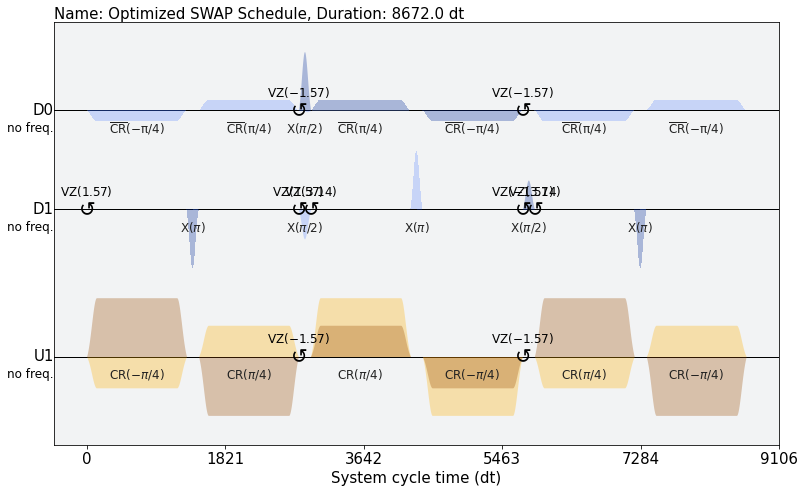

In [138]:
manual_schedule.draw()